# Diagnóstico Precoce de Doenças Cardiovasculares

- Objetivo: Criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.

### PACOTES NECESSÁRIOS

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

### CARREGAMENTO E VISUALIZAÇÃO DO DATASET

In [2]:
df = pd.read_csv('cardio_train.csv', sep = ';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


#### Vamos traduzir o nome das colunas para um melhor entendimento:

In [3]:
df.rename(columns = {'age':'idade', 'gender':'genero','height':'altura','weight':'peso', 
                     'ap_hi':'sistolica','ap_lo':'diastolica','cholesterol':'colesterol',
                     'gluc':'glicose','smoke':'tabagismo','alco':'alcoolismo', 
                     'active':'atividade_fisica','cardio':'diagnostico_cardiovascular'}, inplace = True)

### ANÁLISE EXPLORATÓRIA DOS DADOS - EDA

In [4]:
def infos(data):
    print("##################### Shape #####################")
    print(data.shape)
    print("##################### Types #####################")
    print(data.dtypes)
    print("##################### NA #####################")
    print(data.isnull().sum())

infos(df)

##################### Shape #####################
(70000, 13)
##################### Types #####################
id                              int64
idade                           int64
genero                          int64
altura                          int64
peso                          float64
sistolica                       int64
diastolica                      int64
colesterol                      int64
glicose                         int64
tabagismo                       int64
alcoolismo                      int64
atividade_fisica                int64
diagnostico_cardiovascular      int64
dtype: object
##################### NA #####################
id                            0
idade                         0
genero                        0
altura                        0
peso                          0
sistolica                     0
diastolica                    0
colesterol                    0
glicose                       0
tabagismo                     0
alcoolismo   

### É PRECISO MUDAR A COLUNA "AGE - IDADE" PARA UM FORMATO CORRETO DE ANOS

In [5]:
df['idade'] = round(df['idade'] / 365)
df.head()

,id,idade,genero,altura,peso,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular
0,0,50.0,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.0,1,156,85.0,140,90,3,1,0,0,1,1
2,2,52.0,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.0,2,169,82.0,150,100,1,1,0,0,1,1
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.describe()

,id,idade,genero,altura,peso,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular
count,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000,70000.000000
mean,49972.419900,53.338686,1.349571,164.359229,74.205690,128.817286,96.630414,1.366871,1.226457,0.088129,0.053771,0.803729,0.499700
std,28851.302323,6.765294,0.476838,8.210126,14.395757,154.011419,188.472530,0.680250,0.572270,0.283484,0.225568,0.397179,0.500003
min,0.000000,30.000000,1.000000,55.000000,10.000000,-150.000000,-70.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25006.750000,48.000000,1.000000,159.000000,65.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
50%,50001.500000,54.000000,1.000000,165.000000,72.000000,120.000000,80.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000
75%,74889.250000,58.000000,2.000000,170.000000,82.000000,140.000000,90.000000,2.000000,1.000000,0.000000,0.000000,1.000000,1.000000
max,99999.000000,65.000000,2.000000,250.000000,200.000000,16020.000000,11000.000000,3.000000,3.000000,1.000000,1.000000,1.000000,1.000000


- ### Podemos notar que na feature altura, temos um valor máximo de 250, ou seja, 2 metros e 50 cm, e na feature peso máximo de 200kg, achei muito estranho, precisamos checar os OUTLIERS no dataset.

### OUTLIERS

Text(0.5, 1.0, 'Outlier Altura')

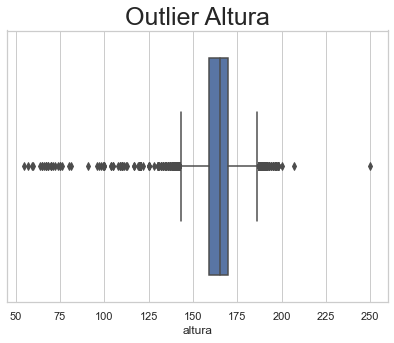

In [7]:
plt.figure(figsize =(15, 5))
sns.set_theme(style="whitegrid")
plt.subplot(1, 2, 1)
sns.boxplot(df['altura'])
plt.title('Outlier Altura', fontsize = 25)

Text(0.5, 1.0, 'Outlier Peso')

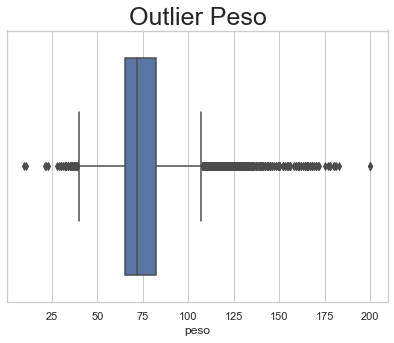

In [8]:
plt.figure(figsize =(15, 5))
sns.set_theme(style="whitegrid")
plt.subplot(1, 2, 1)
sns.boxplot(df['peso'])
plt.title('Outlier Peso', fontsize = 25)

Text(0.5, 1.0, 'Outlier Sistólica')

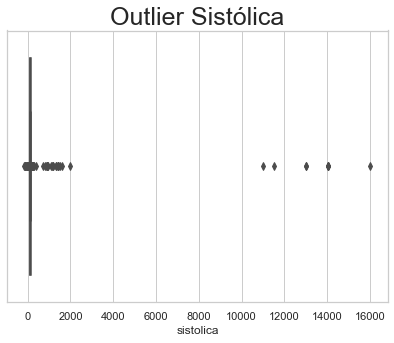

In [9]:
plt.figure(figsize =(15, 5))
sns.set_theme(style="whitegrid")
plt.subplot(1, 2, 1)
sns.boxplot(df['sistolica'])
plt.title('Outlier Sistólica', fontsize = 25)

Text(0.5, 1.0, 'Outlier Diastólica')

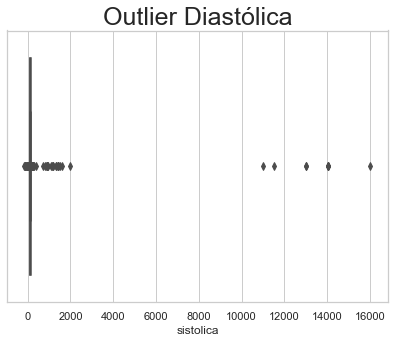

In [10]:
plt.figure(figsize =(15, 5))
sns.set_theme(style="whitegrid")
plt.subplot(1, 2, 1)
sns.boxplot(df['sistolica'])
plt.title('Outlier Diastólica', fontsize = 25)

### Identificando Outliers com Z-Score

- #### O Z-Score nos dá uma idéia do quanto um determinado ponto está afastado da média dos dados.
- #### Mede quantos desvios padrões abaixo ou acima da média populacional ou amostral os dados estão.



In [11]:
# EXEMPLO USANDO ALTURA 

outliers = []

def busca_outliers(data):
    corte_dp = 9
    media = np.mean(data)
    dp = np.std(data)
    
    for dado in data:
        z_score = (dado - media) / dp
        if np.abs(z_score) >= corte_dp:
            outliers.append(dado)
    return outliers

outliers = busca_outliers(df['altura'])
print(outliers)

#outliers_df = pd.DataFrame(outliers)
#outliers_df

[76, 250, 70, 75, 71, 67, 70, 74, 68, 55, 81, 80, 64, 60, 72, 65, 65, 68, 75, 67, 70, 67, 59, 66, 57]


### Identificando Outliers com Amplitude Interquartil

#### Percentil:

- #### percentil 25: primeiro quartil
- #### percentil 50: segundo quartil ou mediana
- #### percentil 75: terceiro quartil 

In [12]:
# EXEMPLO USANDO ALTURA

p75, p50 = np.percentile(df['altura'], [75,50])
print('Percentil 75: ', p75)
print('Percentil 50 (mediana): ', p50)

Percentil 75:  170.0
Percentil 50 (mediana):  165.0


### Amplitude Interquartil 

- #### Diferença entre o terceiro quartil(Q3) e o primeiro quartil(Q1)

#### Como determinar Outlier com AI:

- #### Ordena os dados de forma crescente
- #### Calcula primeiro e terceiro quartil
- #### Determina a Amplitude interquartil
- #### Encontre o limite inferior Q1 * 1.5
- #### Encontre o limite superior Q3 * 1.5

In [13]:
# EXEMPLO USANDO ALTURA, PESO, SISTÓLICA E DIASTÓLICA

def AmpInter(data):
    Q1, Q3 = np.percentile(data, [25,75])
    
    print('Primeiro Quartil ou Percentil 25: ', Q1)
    print('Terceiro Quartil ou Percentil 75: ', Q3)
    
    Amp_interquartil = Q3 - Q1
    
    print('Amplitude Interquartil: ', Amp_interquartil)
    
    limite_inferior = Q1 - (1.5 * Amp_interquartil)
    limite_superior = Q3 + (1.5 * Amp_interquartil)

    print('Limite Inferior: ', limite_inferior)
    print('Limite Superior: ', limite_superior)

In [14]:
AmpInter(df.altura)

Primeiro Quartil ou Percentil 25:  159.0
Terceiro Quartil ou Percentil 75:  170.0
Amplitude Interquartil:  11.0
Limite Inferior:  142.5
Limite Superior:  186.5


In [15]:
AmpInter(df.peso)

Primeiro Quartil ou Percentil 25:  65.0
Terceiro Quartil ou Percentil 75:  82.0
Amplitude Interquartil:  17.0
Limite Inferior:  39.5
Limite Superior:  107.5


In [16]:
AmpInter(df.sistolica)

Primeiro Quartil ou Percentil 25:  120.0
Terceiro Quartil ou Percentil 75:  140.0
Amplitude Interquartil:  20.0
Limite Inferior:  90.0
Limite Superior:  170.0


In [17]:
AmpInter(df.diastolica)

Primeiro Quartil ou Percentil 25:  80.0
Terceiro Quartil ou Percentil 75:  90.0
Amplitude Interquartil:  10.0
Limite Inferior:  65.0
Limite Superior:  105.0


- ### Vamos filtrar os valores de outliers de cada feature detectada.

In [18]:
# ALTURA 

df = df[(df['altura'] > 140) & (df['altura'] < 200)]
df.altura.max()

198

In [19]:
# PESO

df = df[(df['peso'] > 40) & (df['peso'] < 150)]
df.peso.max()

149.0

In [20]:
# SISTOLICA E DIASTOLICA 

df = df[((df['sistolica'] >= 220) | (df['sistolica'] <= 90) | (df['diastolica'] >= 150) | (df['diastolica'] <= 65))]
df.sistolica.max()

16020

As causas das doenças cardiovasculares estão relacionadas com a predisposição genética e fatores de risco comportamentais, como o sedentarismo, alimentação calórica e gordurosa, colesterol alto, sobrepeso, consumo excessivo de álcool e tabagismo são os principais.

#### O que é IMC? 

IMC significa Índice de Massa Corporal e é um parâmetro utilizado para saber se o peso está de acordo com a altura, o que pode interferir diretamente na saúde e qualidade de vida da pessoa. Assim, a partir do resultado do IMC é possível saber também se a pessoa está dentro do peso ideal e também identificar sobrepeso, obesidade ou desnutrição em crianças, adolescentes, adultos ou idosos.

    - Magreza, quando o resultado é menor que 18,5 kg/m2;
    - Normal, quando o resultado está entre 18,5 e 24,9 kg/m2;
    - Sobrepeso, quando o resultado está entre 24,9 e 30 kg/m2;
    - Obesidade, quando o resultado é maior que 30 kg/m2.

- IMC = peso / (altura x altura)


### É preciso criar uma nova coluna IMC com os dados de IMC de cada pessoa (ID).

In [21]:
df['IMC'] = df['peso'] / df['altura'] / df['altura'] * 10000
df.head()

,id,idade,genero,altura,peso,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular,IMC
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,23.011177
9,14,54.0,1,164,68.0,110,60,1,1,0,0,0,0,25.282570
23,33,64.0,2,156,45.0,110,60,1,1,0,0,1,0,18.491124
43,58,56.0,2,159,63.0,120,60,1,1,0,0,1,1,24.919900
50,65,50.0,1,160,75.0,100,60,1,1,0,0,0,0,29.296875


###  É preciso criar uma nova coluna com as divisões do IMC: Magresa, Normal, Sobrepeso, Obesidade e Obesidade Mórbida

In [22]:
df['status_IMC'] = df['IMC'].apply(lambda x: '1' if x <= 18.5
                                  else '2' if (x > 18.5) & (x < 24.9)
                                  else '3' if (x > 24.9) & (x < 29.9)
                                  else '4' if (x >= 30) & (x <= 34.9)
                                  else '5')
df.head()

,id,idade,genero,altura,peso,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular,IMC,status_IMC
4,4,48.0,1,156,56.0,100,60,1,1,0,0,0,0,23.011177,2
9,14,54.0,1,164,68.0,110,60,1,1,0,0,0,0,25.282570,3
23,33,64.0,2,156,45.0,110,60,1,1,0,0,1,0,18.491124,1
43,58,56.0,2,159,63.0,120,60,1,1,0,0,1,1,24.919900,3
50,65,50.0,1,160,75.0,100,60,1,1,0,0,0,0,29.296875,3


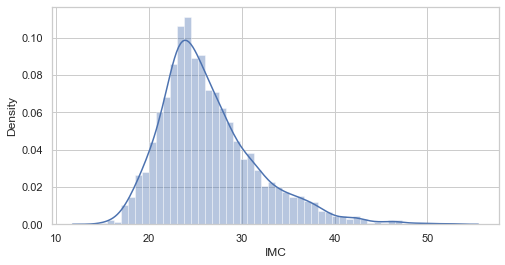

In [23]:
plt.figure(figsize=(8,4))
sns.distplot(df['IMC'], bins=50, kde=True)
plt.show()

### Removendo Peso e Altura do dataframe

In [24]:
df1 = df.drop(['peso','altura'], axis = 1)
df1.head()

,id,idade,genero,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular,IMC,status_IMC
4,4,48.0,1,100,60,1,1,0,0,0,0,23.011177,2
9,14,54.0,1,110,60,1,1,0,0,0,0,25.282570,3
23,33,64.0,2,110,60,1,1,0,0,1,0,18.491124,1
43,58,56.0,2,120,60,1,1,0,0,1,1,24.919900,3
50,65,50.0,1,100,60,1,1,0,0,0,0,29.296875,3


#### Pressão Arterial - Hipertensão

A hipertensão é uma doença silenciosa, que em geral só causa sintomas quando está instalada há muito tempo e já comprometeu o funcionamento de vários órgãos. É responsável pelo aumento do risco de AVC e ataques cardíacos, entre outras doenças, além de poder lesar os rins, a retina e as artérias periféricas e levar à insuficiência renal, à perda da visão e a amputações de membros, respectivamente.

As causas da pressão alta são múltiplas: obesidade, genética, sedentarismo, estresse, influência do meio ambiente e do tipo de alimentação etc.

Para controlar a pressão, é importante medi-la com frequência (saiba como fazê-lo corretamente aqui). Muita gente já está familiarizada com o clássico 12 por 8, considerada a medida normal para pressão arterial. Pessoas com hipertensão e que possuem aparelho para medir a pressão em casa podem ficar em dúvida caso seus resultados saiam com números um pouco diferentes dessa marca, tanto para cima como para baixo.

- Normal -> Sistólica menor que 120 e diastólica menor que 80
- Elevada -> Sistólica entre 120-129 e diastólica menor que 80
- Pressão alta -> sistólica entre 130-139 e diastólica entre 80-89
- Hipertensão -> Sistólica acima de 140 e diastólica igual ou acima de 90.


### É preciso criar uma nova coluna com as divisões da Pressão Arterial - Hipertensão

In [25]:
df1['pressao_arterial'] = df1.apply(lambda x:'1' if (x['sistolica'] <= 120) & (x['diastolica'] <= 80)
                                 else '2' if (x['sistolica'] > 120 and x['sistolica'] <= 129) & (x['diastolica'] <= 80)
                                 else "3" if (x['sistolica'] >= 130 and x['sistolica'] <= 139) & (x['diastolica'] <= 90)
                                 else '4', axis = 1)
df1.head(10)

,id,idade,genero,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular,IMC,status_IMC,pressao_arterial
4,4,48.0,1,100,60,1,1,0,0,0,0,23.011177,2,1
9,14,54.0,1,110,60,1,1,0,0,0,0,25.282570,3,1
23,33,64.0,2,110,60,1,1,0,0,1,0,18.491124,1,1
43,58,56.0,2,120,60,1,1,0,0,1,1,24.919900,3,1
50,65,50.0,1,100,60,1,1,0,0,0,0,29.296875,3,1
56,71,48.0,1,90,60,1,2,0,0,1,0,25.990903,3,1
85,116,50.0,1,100,60,1,1,0,0,1,0,22.600263,2,1
113,149,52.0,1,125,65,1,2,0,0,1,1,32.049982,4,2
151,204,59.0,1,120,60,1,1,0,0,1,1,26.171875,3,1
176,239,46.0,1,120,63,1,1,0,0,1,0,25.854639,3,1


- ### Analisando os dados agora, vemos algo estranho, existem pessoas que são magras, mas são hipertensas, e pessoas que são normais, mas possuem pressão alta, vamos comparar esses dados com os diagnósticos cardiovasculares.

In [26]:
# PESSOAS MAGRAS E PRESSAO ARTERIAL NORMAL

imc1_pa1 = df1[(df1['status_IMC'] == 'Magreza') & (df1['pressao_arterial'] == 'Normal')]
imc1_pa1.value_counts('diagnostico_cardiovascular')


Series([], dtype: int64)

In [27]:
# PESSOAS MAGRAS E PRESSAO ARTERIAL ELEVADA

imc2_pa2 = df1[(df1['status_IMC'] == 'Magreza') & (df1['pressao_arterial'] == 'Elevada')]
imc2_pa2.value_counts('diagnostico_cardiovascular')

Series([], dtype: int64)

In [28]:
# PESSOAS MAGRAS E PRESSAO ARTERIAL ALTA

imc3_pa3 = df1[(df1['status_IMC'] == 'Magreza') & (df1['pressao_arterial'] == 'Pressao_Alta')]
imc3_pa3.value_counts('diagnostico_cardiovascular')

Series([], dtype: int64)

In [29]:
# PESSOAS NORMAIS E PRESSAO ALTA

imc4_pa4 = df1[(df1['status_IMC'] == 'Magreza') & (df1['pressao_arterial'] == 'Hipertensao')]
imc4_pa4.value_counts('diagnostico_cardiovascular')

Series([], dtype: int64)

In [30]:
# PESSOAS COM OBESIDADE MORBIDA E PRESSAO ARTERIAL NORMAL 

imc5_pa5 = df1[(df1['status_IMC'] == 'Obesidade_Morbida') & (df1['pressao_arterial'] == 'Normal')]
imc5_pa5.value_counts('diagnostico_cardiovascular')

Series([], dtype: int64)

- ### Podemos concluir que não necessariamente a pressão arterial influi no IMC de cada pessoa para causar problemas cardiovasculares.

### CORRELAÇÃO

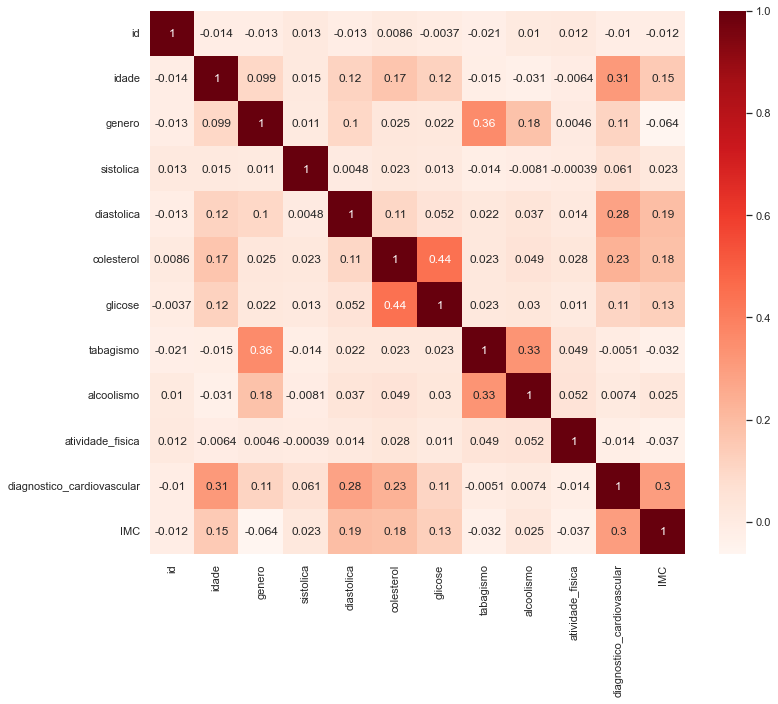

In [31]:
plt.figure(figsize = (12,10))
corr = df1.corr()
sns.heatmap(corr, annot = True, cmap = plt.cm.Reds)
plt.show()

In [32]:
df_corr = df1.corr()
df_corr['diagnostico_cardiovascular'].sort_values(ascending = False).round(3)

diagnostico_cardiovascular    1.000
idade                         0.312
IMC                           0.300
diastolica                    0.282
colesterol                    0.235
genero                        0.112
glicose                       0.109
sistolica                     0.061
alcoolismo                    0.007
tabagismo                    -0.005
id                           -0.010
atividade_fisica             -0.014
Name: diagnostico_cardiovascular, dtype: float64

### Vamos analisar o diagnóstico cardiovascular com relação ao colesterol, glicose, tabagismo, alcoolismo e atividade fisica:

diagnostico_cardiovascular  colesterol
0                           1             2218
                            2              340
                            3               91
1                           1             1159
                            2              336
                            3              264
Name: colesterol, dtype: int64


<AxesSubplot:xlabel='diagnostico_cardiovascular', ylabel='count'>

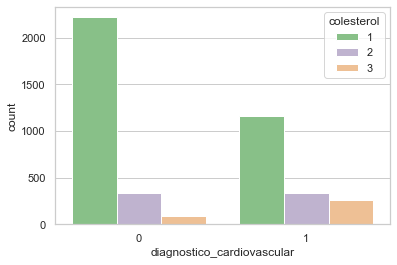

In [33]:
# colesterol | 1: normal, 2: acima do normal, 3: muito acima do normal 

diag_colesterol = df1.groupby('diagnostico_cardiovascular')['colesterol'].value_counts()
print(diag_colesterol)
sns.countplot(x='diagnostico_cardiovascular', hue = 'colesterol', data = df1, palette='Accent')

- ### Podemos concluir que o colesterol 2 - acima do normal, e 3 - muito acima do normal não influenciam tanto no diagnóstico cardiovascular.

diagnostico_cardiovascular  glicose
0                           1          2363
                            2           174
                            3           112
1                           1          1438
                            2           171
                            3           150
Name: glicose, dtype: int64


<AxesSubplot:xlabel='diagnostico_cardiovascular', ylabel='count'>

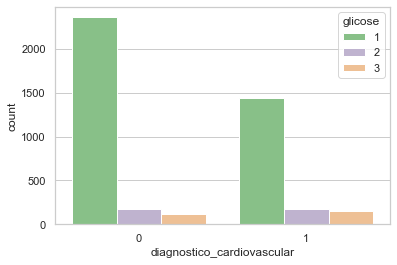

In [34]:
# glicose | 1: normal, 2: acima do normal, 3: muito acima do normal 

diag_glicose = df1.groupby('diagnostico_cardiovascular')['glicose'].value_counts()
print(diag_glicose)
sns.countplot(x='diagnostico_cardiovascular', hue = 'glicose', data = df1, palette='Accent')

- ### Podemos concluir que a glicose 2 - acima do normal, e 3 - muito acima do normal não influenciam tanto no diagnóstico cardiovascular.

diagnostico_cardiovascular  tabagismo
0                           0            2423
                            1             226
1                           0            1614
                            1             145
Name: tabagismo, dtype: int64


<AxesSubplot:xlabel='diagnostico_cardiovascular', ylabel='count'>

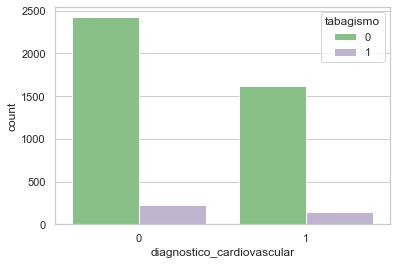

In [35]:
diag_tabagismo = df1.groupby('diagnostico_cardiovascular')['tabagismo'].value_counts()
print(diag_tabagismo)
sns.countplot(x='diagnostico_cardiovascular', hue = 'tabagismo', data = df1, palette='Accent')

- ### Podemos concluir que o tabagismo não influencia tanto no diagnóstico cardiovascular.

diagnostico_cardiovascular  alcoolismo
0                           0             2509
                            1              140
1                           0             1660
                            1               99
Name: alcoolismo, dtype: int64


<AxesSubplot:xlabel='diagnostico_cardiovascular', ylabel='count'>

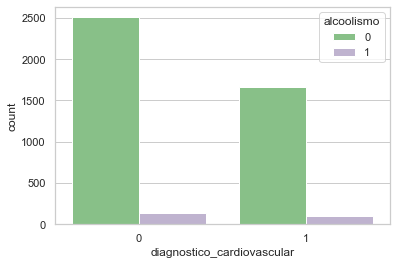

In [36]:
diag_alcoolismo = df1.groupby('diagnostico_cardiovascular')['alcoolismo'].value_counts()
print(diag_alcoolismo)
sns.countplot(x='diagnostico_cardiovascular', hue = 'alcoolismo', data = df1, palette='Accent')

- ### Podemos concluir que o alcoolismo não influencia tanto no diagnóstico cardiovascular.

diagnostico_cardiovascular  atividade_fisica
0                           1                   2159
                            0                    490
1                           1                   1414
                            0                    345
Name: atividade_fisica, dtype: int64


<AxesSubplot:xlabel='diagnostico_cardiovascular', ylabel='count'>

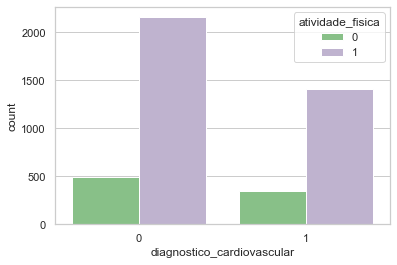

In [37]:
diag_ativ_fisica = df1.groupby('diagnostico_cardiovascular')['atividade_fisica'].value_counts()
print(diag_ativ_fisica)
sns.countplot(x='diagnostico_cardiovascular', hue = 'atividade_fisica', data = df1, palette='Accent')

- ### Podemos concluir que atividade física influencia no diagnóstico cardiovascular, e não a falta.

### MODELAGEM

In [38]:
df1.head()

,id,idade,genero,sistolica,diastolica,colesterol,glicose,tabagismo,alcoolismo,atividade_fisica,diagnostico_cardiovascular,IMC,status_IMC,pressao_arterial
4,4,48.0,1,100,60,1,1,0,0,0,0,23.011177,2,1
9,14,54.0,1,110,60,1,1,0,0,0,0,25.282570,3,1
23,33,64.0,2,110,60,1,1,0,0,1,0,18.491124,1,1
43,58,56.0,2,120,60,1,1,0,0,1,1,24.919900,3,1
50,65,50.0,1,100,60,1,1,0,0,0,0,29.296875,3,1


In [39]:
X = df1.drop(['id','diagnostico_cardiovascular'], axis = 1)
y = df['diagnostico_cardiovascular']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 17)

In [40]:
std_scaler = StandardScaler()
X_train = std_scaler.fit_transform(X_train)
X_test = std_scaler.fit_transform(X_test)

In [41]:
len(X_train)

3085

In [42]:
len(y_train)

3085

### Random Forest Model Investigation

In [43]:
RFC = RandomForestClassifier(n_estimators = 100)
RFC.fit(X_train, y_train)

RandomForestClassifier()

In [44]:
y_pred_RFC = RFC.predict(X_test)

In [45]:
print(confusion_matrix(y_test, y_pred_RFC))
print(classification_report(y_test, y_pred_RFC))

[[639 144]
 [157 383]]
              precision    recall  f1-score   support

           0       0.80      0.82      0.81       783
           1       0.73      0.71      0.72       540

    accuracy                           0.77      1323
   macro avg       0.76      0.76      0.76      1323
weighted avg       0.77      0.77      0.77      1323



In [46]:
RFC.score(X_test, y_test)

0.7724867724867724

### K-Fold cross-validation of Random Forest Model

In [47]:
accuracies_RFC = cross_val_score(estimator = RFC, X = X_train, y = y_train, cv = 10)
accuracies_RFC

array([0.78640777, 0.76375405, 0.76699029, 0.77993528, 0.72168285,
       0.73376623, 0.78571429, 0.78896104, 0.74675325, 0.76623377])

In [48]:
accuracies_RFC.mean()

0.7640198797965787

In [49]:
accuracies_RFC.std()

0.022060972913602213

### SVM Model Investigation

In [50]:
svc = SVC(gamma = 'auto')
svc.fit(X_train, y_train)

SVC(gamma='auto')

In [51]:
y_pred_SVC = svc.predict(X_test)

In [52]:
print(confusion_matrix(y_test, y_pred_SVC))
print(classification_report(y_test, y_pred_SVC))

[[689  94]
 [181 359]]
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       783
           1       0.79      0.66      0.72       540

    accuracy                           0.79      1323
   macro avg       0.79      0.77      0.78      1323
weighted avg       0.79      0.79      0.79      1323



In [53]:
svc.score(X_test, y_test)

0.7921390778533636

### K-Fold cross-validation of SVM model

In [54]:
accuracies_SVC = cross_val_score(estimator = svc, X = X_train, y = y_train, cv = 10, n_jobs = 4)
accuracies_SVC

array([0.76699029, 0.79935275, 0.77346278, 0.81553398, 0.73139159,
       0.77922078, 0.79220779, 0.81168831, 0.78246753, 0.78571429])

In [55]:
accuracies_SVC.mean()

0.7838030092884462

In [56]:
accuracies_SVC.std()

0.02293437998854618

### K-Nearest Neighbor Model Investigation

In [57]:
knn = KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=100)

In [58]:
y_pred_KNN = knn.predict(X_test)

In [59]:
print(confusion_matrix(y_test, y_pred_KNN))
print(classification_report(y_test, y_pred_KNN))

[[709  74]
 [221 319]]
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       783
           1       0.81      0.59      0.68       540

    accuracy                           0.78      1323
   macro avg       0.79      0.75      0.76      1323
weighted avg       0.78      0.78      0.77      1323



In [60]:
knn.score(X_test, y_test)

0.7770219198790628

### K-Fold cross-validation of KNN model

In [61]:
accuracies_KNN = cross_val_score(estimator = knn, X = X_train, y = y_train, cv = 10)
accuracies_KNN

array([0.77022654, 0.78640777, 0.77022654, 0.79935275, 0.74757282,
       0.76948052, 0.76948052, 0.79545455, 0.76948052, 0.76623377])

In [62]:
accuracies_KNN.mean()

0.7743916277896861

In [63]:
accuracies_KNN.std()

0.014504978709529376

### Naive Bayes Model Investigation

In [64]:
nbc = GaussianNB()
nbc.fit(X_train, y_train)

GaussianNB()

In [65]:
y_pred_NBC = nbc.predict(X_test)

In [66]:
print(confusion_matrix(y_test, y_pred_NBC))
print(classification_report(y_test, y_pred_NBC))

[[671 112]
 [188 352]]
              precision    recall  f1-score   support

           0       0.78      0.86      0.82       783
           1       0.76      0.65      0.70       540

    accuracy                           0.77      1323
   macro avg       0.77      0.75      0.76      1323
weighted avg       0.77      0.77      0.77      1323



In [67]:
nbc.score(X_test, y_test)

0.7732426303854876

### K-Fold cross-validation of Naive Bayes model

In [68]:
accuracies_NBC = cross_val_score(estimator = nbc, X = X_train, y = y_train, cv = 10)
accuracies_NBC

array([0.7961165 , 0.77669903, 0.74433657, 0.80906149, 0.76375405,
       0.75324675, 0.78571429, 0.77922078, 0.75324675, 0.76948052])

In [69]:
accuracies_NBC.mean()

0.7730876728449545

In [70]:
accuracies_NBC.std()

0.01936132497511067

### XGBoost Model Investigation

In [71]:
xgb = XGBClassifier(learning_rate = 0.02, n_estimators = 600)
xgb.fit(X_train, y_train)

[18:27:20] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.02, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=600, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [72]:
y_pred_XGB = xgb.predict(X_test)

In [73]:
print(confusion_matrix(y_test, y_pred_XGB))
print(classification_report(y_test, y_pred_XGB))

[[624 159]
 [137 403]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       783
           1       0.72      0.75      0.73       540

    accuracy                           0.78      1323
   macro avg       0.77      0.77      0.77      1323
weighted avg       0.78      0.78      0.78      1323



In [74]:
xgb.score(X_test, y_test)

0.7762660619803476

### K-Fold cross-validation of XGBoost model

In [75]:
accuracies_XGB = cross_val_score(estimator = xgb, X = X_train, y = y_train, cv = 10)
accuracies_XGB

[18:27:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[18:27:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

array([0.79288026, 0.77022654, 0.74757282, 0.78640777, 0.76699029,
       0.75974026, 0.76623377, 0.7987013 , 0.75324675, 0.77922078])

In [76]:
accuracies_XGB.mean()

0.7721220527045769

In [77]:
accuracies_XGB.std()

0.016027113393615473

### Conclusão

- #### O modelo SVM teve o melhor desempenho dos cinco modelos, dando-nos uma pontuação média de precisão de 78,3%.
- #### A validação cruzada K-Fold foi usada para garantir que nenhum overfitting fosse feito.

In [78]:
model = ['Random Forest', 'SVM', 'KNN', 'Naive Bayes', 'XGBoost']
scores = [accuracies_RFC.mean(), accuracies_SVC.mean(), accuracies_KNN.mean(), accuracies_NBC.mean(), accuracies_XGB.mean()]

summary = pd.DataFrame(data = scores, index = model, columns = ['Média Acúracia'])
summary.sort_values(by = 'Média Acúracia', ascending = False)

,Média Acúracia
SVM,0.783803
KNN,0.774392
Naive Bayes,0.773088
XGBoost,0.772122
Random Forest,0.764020
